In [1]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torchvision as p
import torchvision.transforms as transforms
import os
import time
import json
import cv2 as cv
import argparse

In [2]:
import pandas as pd
cp = pd.read_csv('/home/haoying/res_zl12/center2PA.csv')
df = pd.read_csv('/home/haoying/res_zl12_effnet_v3/nightlight_predicted_all.csv')

In [3]:
df.columns = ['name','cluster_lat','cluster_lon','nightlights','predict']

### 图片粒度的相关性

In [55]:
n0 = pd.read_csv('/home/haoying/res_zl12_effnet_v3/nightlights_labeled0.csv')
n1 = pd.read_csv('/home/haoying/res_zl12_effnet_v3/nightlights_labeled1.csv')
n2 = pd.read_csv('/home/haoying/res_zl12_effnet_v3/nightlights_labeled2.csv')
print(len(n0),len(n1),len(n2))
print(len(n0)/(len(n0)+len(n1)+len(n2)),len(n1)/(len(n0)+len(n1)+len(n2)),len(n2)/(len(n0)+len(n1)+len(n2)))

10086 9947 2811
0.44151637191385046 0.4354316231833304 0.12305200490281912


In [4]:
def Normalization(x):
    return [(float(i)-np.min(x))/float(np.max(x)-np.min(x)) for i in x]
df['predict_norm'] = Normalization(df['predict'])

In [7]:
df['predict_norm'].quantile(0.5)

0.19540494815077974

In [21]:
# pd.qcut(df['predict_norm'],10).unique().categories[0].left
cate = pd.qcut(df['predict_norm'],10).unique().categories
cate[0].left,cate[0].right

(-0.001, 0.132)

In [12]:
data_coor={df['name'][i]: [df['cluster_lon'][i], df['cluster_lat'][i]] for i in range(len(df))} #create a dictionary with coordinates
data_o3=[(df['name'][i], df['predict_norm'][i]) for i in range(len(df))] #map the data to the objects

In [29]:
import seaborn as sns
sns.color_palette('RdBu_r')[-1]

(0.7561707035755478, 0.21038062283737025, 0.22352941176470587)

In [59]:
color_list = plt.cm.RdBu_r(np.linspace(0, 1, 10))
color_list
sns.color_palette(color_list)

[(0.0196078431372549, 0.18823529411764706, 0.3803921568627451),
 (0.142483660130719, 0.4173010380622838, 0.6833525567089581),
 (0.32349096501345653, 0.6149173394848136, 0.7854671280276817),
 (0.6549019607843138, 0.8143790849673204, 0.8941176470588236),
 (0.8838908112264514, 0.9284890426758939, 0.9530180699730872),
 (0.982006920415225, 0.9061899269511726, 0.8615916955017301),
 (0.9686274509803922, 0.7176470588235294, 0.6),
 (0.8622837370242215, 0.42952710495963087, 0.34271434063821604),
 (0.7118800461361015, 0.12179930795847749, 0.18169934640522878),
 (0.403921568627451, 0.0, 0.12156862745098039)]

In [61]:
color_list[0].tolist()

[0.0196078431372549, 0.18823529411764706, 0.3803921568627451, 1.0]

In [73]:
def RGB_to_Hex(rgb):
    color = '#'
    for i in rgb:
        num = int(i*255)
        # 将R、G、B分别转化为16进制拼接转换并大写  hex() 函数用于将10进制整数转换成16进制，以字符串形式表示
        color += str(hex(num))[-2:].replace('x', '0').upper()
#     print(color)
    return color

cc = []
for i in color_list:
#     print(i)
    cl = RGB_to_Hex(i[:3])
    cc.append(cl)
cc

['#053061',
 '#246AAE',
 '#529CC8',
 '#A7CFE4',
 '#E1ECF3',
 '#FAE7DB',
 '#F7B799',
 '#DB6D57',
 '#B51F2E',
 '#67001F']

In [74]:
# 预测的分的可视化
import pandas as pd 
from pyecharts import options as opts 
from pyecharts.charts import Geo 
from pyecharts.globals import ChartType, SymbolType 
map_o3=Geo() #initialisation
map_o3.add_schema(maptype="china") #set to China
for ind, value in data_coor.items(): 
     map_o3.add_coordinate(ind, value[0], value[1]) #add points with a loop

map_o3.add("", data_o3, symbol_size=1.5) #add ozone concentrations
map_o3.set_series_opts(label_opts=opts.LabelOpts(is_show=False), type='scatter')  #plot a scatter


legend = [
        {'max': cate[0].right, 'label': "0~"+str(cate[0].right), 'color':cc[0]},
        {'min': cate[1].left, 'max': cate[1].right, 'label': str(cate[1].left)+"~"+str(cate[1].right), 'color': cc[1]},
        {'min': cate[2].left, 'max': cate[2].right, 'label': str(cate[2].left)+"~"+str(cate[2].right), 'color': cc[2]},
#         {'min': 0.2, 'max': 0.3, 'label': '0.2~0.3', 'color': 'lightblue'},
        {'min': cate[3].left, 'max': cate[3].right, 'label': str(cate[3].left)+"~"+str(cate[3].right), 'color':cc[3]},
        {'min': cate[4].left, 'max': cate[4].right,'label': str(cate[4].left)+"~"+str(cate[4].right), 'color':cc[4]}, #legend
        {'min': cate[5].left, 'max': cate[5].right, 'label': str(cate[5].left)+"~"+str(cate[5].right), 'color': cc[5]},
        {'min': cate[6].left, 'max': cate[6].right,'label':str(cate[6].left)+"~"+str(cate[6].right), 'color': cc[6]},
        {'min': cate[7].left, 'max': cate[7].right, 'label': str(cate[7].left)+"~"+str(cate[7].right), 'color':cc[7]},
        {'min': cate[8].left, 'max': cate[8].right,'label': str(cate[8].left)+"~"+str(cate[8].right), 'color': cc[8]},
        {'min': cate[9].left, 'max': cate[9].right,'label':str(cate[9].left)+"~"+str(cate[9].right), 'color':cc[9]}
         ]

map_o3.set_global_opts(visualmap_opts=opts.VisualMapOpts(is_piecewise=True, pieces=legend,range_text=['预测指数'])) 
map_o3.render("/home/haoying/res_zl12_effnet_v3/chn_图片粒度预测得分分布图.html")
# ,range_opacity=0.7

'/home/haoying/res_zl12_effnet_v3/chn_图片粒度预测得分分布图.html'

In [17]:
# 相关性
df[['nightlights','predict']].corr('spearman')

,nightlights,predict
nightlights,1.000000,0.549503
predict,0.549503,1.000000


In [18]:
road_net_97km = pd.read_csv('/home/haoying/road_network_9.7km.csv')
road_97km = pd.merge(df,road_net_97km,left_on='name',right_on='image_id',how='left')
road_97km['road'] = road_97km['road_network'].apply(lambda x:int(float(x.strip('[]').split(',')[0])) if pd.notnull(x) else x)
road_97km[['road','predict']].corr()

,road,predict
road,1.00000,0.62706
predict,0.62706,1.00000


In [20]:
# 人口
import geoio
tif = geoio.GeoImage('/home/haoying/chn_ppp_2020.tif')
tif_array = np.squeeze(tif.get_data())

In [21]:
def add_ppp(df, tif, tif_array):
    ''' 
    This takes a dataframe with columns cluster_lat, cluster_lon and finds the average 
    nightlights in 2015 using a 10kmx10km box around the point
    
    I try all the nighlights tifs until a match is found, or none are left upon which an error is raised
    '''
    cluster_ppp = []
    for i,r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon,s=9.7)
        
        xminPixel, ymaxPixel = tif.proj_to_raster(min_lon, min_lat)
        xmaxPixel, yminPixel = tif.proj_to_raster(max_lon, max_lat)
        assert xminPixel < xmaxPixel, print(r.cluster_lat, r.cluster_lon)
        assert yminPixel < ymaxPixel, print(r.cluster_lat, r.cluster_lon)
        if xminPixel < 0 or xmaxPixel >= tif_array.shape[1]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        elif yminPixel < 0 or ymaxPixel >= tif_array.shape[0]:
            print(f"no match for {r.cluster_lat}, {r.cluster_lon}")
            raise ValueError()
        xminPixel, yminPixel, xmaxPixel, ymaxPixel = int(xminPixel), int(yminPixel), int(xmaxPixel), int(ymaxPixel)
        tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel][tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel]==-99999.0]=0
        cluster_ppp.append(tif_array[yminPixel:ymaxPixel,xminPixel:xmaxPixel].sum())
        
    df['ppp'] = cluster_ppp

In [22]:
from utils import create_space
add_ppp(road_97km, tif, tif_array)

In [23]:
road_97km[['ppp','predict']].corr()

,ppp,predict
ppp,1.000000,0.526296
predict,0.526296,1.000000


In [31]:
road_97km[['predict','nightlights']].corr('spearman').iloc[0,1]

0.5560203682995674

In [32]:
cor = road_97km[['predict','nightlights','road','ppp']].corr()
# cor.iloc[1,0] = road_97km[['predict','nightlights']].corr('spearman').iloc[0,1]
# cor.iloc[0,1] = road_97km[['predict','nightlights']].corr('spearman').iloc[0,1]

In [49]:
cor.to_csv('/home/haoying/cor.csv')

In [51]:
road_97km[['predict','nightlights','road','ppp']].corr('spearman')

,predict,nightlights,road,ppp
predict,1.000000,0.556020,0.458768,0.328319
nightlights,0.556020,1.000000,0.535745,0.392963
road,0.458768,0.535745,1.000000,0.470305
ppp,0.328319,0.392963,0.470305,1.000000


### 县级数据及相关性

In [75]:
df1 = pd.merge(df,cp,how='left')

In [ ]:
##################################

In [76]:
score = df1.groupby('PAC').agg({'predict':'mean','name':'count'})
score = pd.DataFrame(score).reset_index()
score.columns = ['PAC','predict','pic_num']

In [77]:
res = pd.DataFrame()
res['score'] = df1.groupby('PAC')['predict'].mean()

In [78]:
import geopandas
import json

county_shp = geopandas.GeoDataFrame.from_file('/home/haoying/data/get_shp/县级行政区/县级行政区.shp')
county_shp['ID'] = [i for i in range(county_shp.shape[0])]
county_shp['parent'] = county_shp['parent'].apply(lambda x:json.loads(x).get('adcode'))
county_shp['adcode'] = county_shp['adcode'].astype(str)
county_shp.head()

ERROR 1: PROJ: proj_create_from_database: Open of /home/haoying/anaconda3/envs/torch/share/proj failed
PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


,adcode,name,childrenNu,level,parent,subFeature,geometry,ID
0,110101,东城区,0,district,110000,NaN,"POLYGON ((116.44364 39.87285, 116.44351 39.872...",0
1,110102,西城区,0,district,110000,NaN,"POLYGON ((116.32581 39.89679, 116.32581 39.897...",1
2,110105,朝阳区,0,district,110000,NaN,"MULTIPOLYGON (((116.59555 40.01752, 116.59820 ...",2
3,110106,丰台区,0,district,110000,NaN,"POLYGON ((116.25909 39.89667, 116.26005 39.896...",3
4,110107,石景山区,0,district,110000,NaN,"POLYGON ((116.16703 39.88876, 116.16636 39.889...",4


In [93]:
# df2.to_csv('/home/haoying/res_zl12_effnet_v3/predict_score.csv',index=False)

In [79]:
res1 = county_shp.set_index('adcode').join(res)

In [80]:
res1

,name,childrenNu,level,parent,subFeature,geometry,ID,score
adcode,,,,,,,,
110101,东城区,0,district,110000,NaN,"POLYGON ((116.44364 39.87285, 116.44351 39.872...",0,NaN
110102,西城区,0,district,110000,NaN,"POLYGON ((116.32581 39.89679, 116.32581 39.897...",1,6.000537
110105,朝阳区,0,district,110000,NaN,"MULTIPOLYGON (((116.59555 40.01752, 116.59820 ...",2,6.000586
110106,丰台区,0,district,110000,NaN,"POLYGON ((116.25909 39.89667, 116.26005 39.896...",3,NaN
110107,石景山区,0,district,110000,NaN,"POLYGON ((116.16703 39.88876, 116.16636 39.889...",4,NaN
...,...,...,...,...,...,...,...,...
659006,铁门关市,0,city,650000,NaN,"MULTIPOLYGON (((85.74147 41.75532, 85.74277 41...",2843,4.520817
659007,双河市,0,city,650000,NaN,"MULTIPOLYGON (((82.20696 44.82122, 82.17847 44...",2844,4.529892
659008,可克达拉市,0,city,650000,NaN,"MULTIPOLYGON (((80.67237 43.84470, 80.66106 43...",2845,4.777022


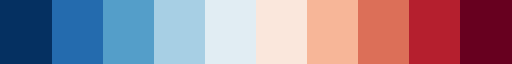

In [81]:
cmap0=plt.get_cmap('RdBu_r',10)
bwr_10 = mpl.colors.LinearSegmentedColormap.from_list('bwr_10', cmap0(np.arange(10)), 10)
bwr_10
# plt.imshow(tem,cmap = bwr_10)
# plt.colorbar(orientation = 'horizontal')

In [85]:
res1['score_norm'] = Normalization(res1['score'])

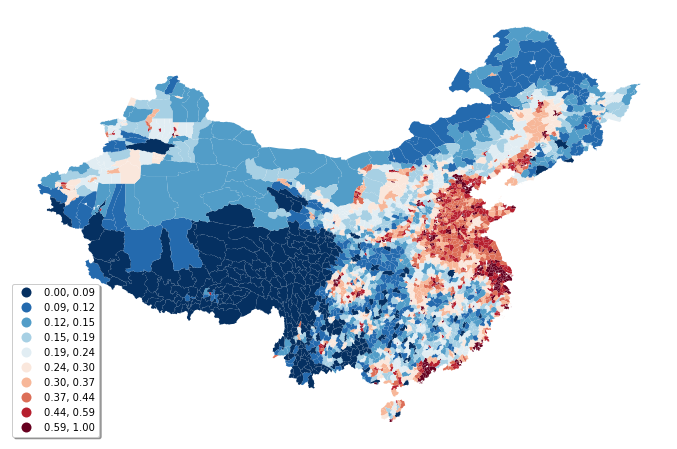

In [114]:
ax = res1.plot(figsize=(12,8),column="score_norm",scheme='Quantiles', k=10, cmap='RdBu_r', legend=True,
               legend_kwds={'loc': 'lower left', 'shadow': True })
# plt.legend(loc="upper left") 
ax.set_xticks([])
ax.set_yticks([])
# plt.show()
ax.set_axis_off()

<AxesSubplot:>

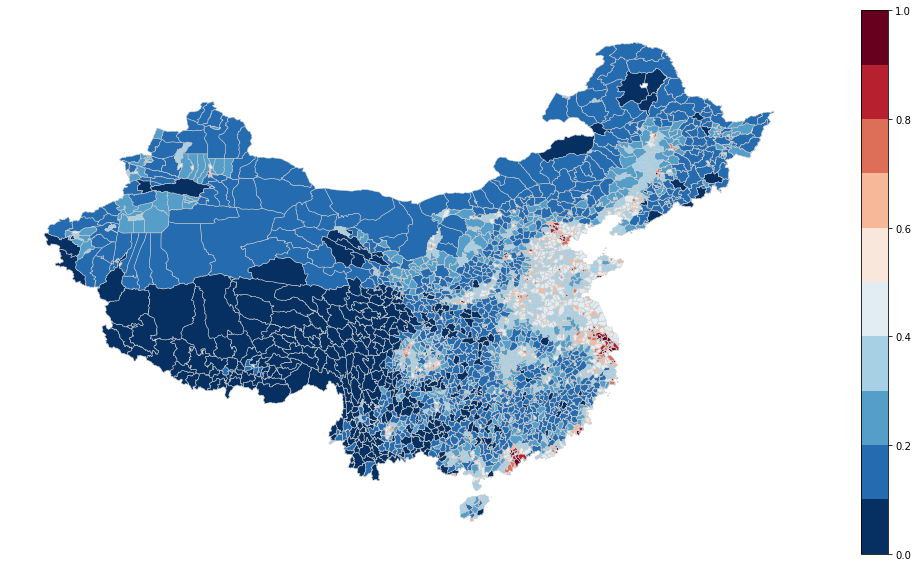

In [86]:
%matplotlib inline

# set a variable that will call whatever column we want to visualise on the map
variable = 'score_norm'
# set the range for the choropleth
vmin, vmax = 0, 1
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False) 
ax.get_xaxis().set_visible(False) 

res1.plot(column=variable, cmap=bwr_10,k=10,vmin=vmin,vmax=vmax,
          linewidth=0.5, ax=ax, edgecolor='0.8',legend=True)


In [97]:
prov_shp = geopandas.GeoDataFrame.from_file('/home/haoying/data/get_shp/省级行政区/省级行政区.shp')
# county_shp['ID'] = [i for i in range(county_shp.shape[0])]
# county_shp['parent'] = county_shp['parent'].apply(lambda x:json.loads(x).get('adcode'))
# county_shp['adcode'] = county_shp['adcode'].astype(str)
prov_shp.head()

,adcode,name,childrenNu,level,parent,subFeature,adchar,geometry
0,110000,北京市,16.0,province,"{""adcode"": 100000}",0.0,None,"POLYGON ((117.34861 40.58114, 117.34861 40.581..."
1,120000,天津市,16.0,province,"{""adcode"": 100000}",1.0,None,"MULTIPOLYGON (((117.76560 39.40053, 117.69970 ..."
2,130000,河北省,11.0,province,"{""adcode"": 100000}",2.0,None,"MULTIPOLYGON (((117.46749 40.64974, 117.46749 ..."
3,140000,山西省,11.0,province,"{""adcode"": 100000}",3.0,None,"POLYGON ((110.37926 34.60061, 110.29549 34.610..."
4,150000,内蒙古自治区,12.0,province,"{""adcode"": 100000}",4.0,None,"POLYGON ((97.17290 42.79526, 97.28254 42.78208..."


In [95]:
eco = pd.read_csv('/home/haoying/eco.csv')
eco['adcode'] = eco['adcode'].apply(lambda x :str(x)[:6])
res1 = res1.reset_index()
res2 = pd.merge(res1,eco,how='left')

In [98]:
pro_score = pd.DataFrame()
pro_score['pro_score'] = res2.groupby('province')['score'].mean()
res3 = prov_shp.set_index('name').join(pro_score)

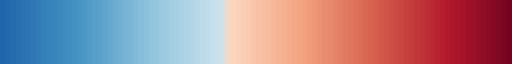

In [99]:
cmap0=plt.get_cmap('RdBu_r',100)
bwr_10 = mpl.colors.LinearSegmentedColormap.from_list('bwr_10', cmap0(np.arange(10,40).tolist()+np.arange(60,98).tolist()), 100)
bwr_10

In [107]:
# res3 = res3.iloc[:-4]
# res3

/home/haoying/anaconda3/envs/torch/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


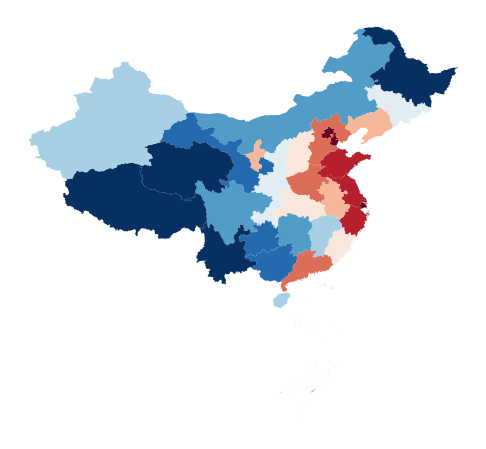

In [113]:
res3['score_norm'] = Normalization(res3['pro_score'])
ax = res3.plot(figsize=(12,8),column="score_norm",scheme='Quantiles', k=10, cmap='RdBu_r', legend=False,
               legend_kwds={'loc': 'lower left', 'shadow': True })
# plt.legend(loc="upper left") 
# ax.set_xticks([])
# ax.set_yticks([])

ax.set_axis_off()
plt.show()

<AxesSubplot:>

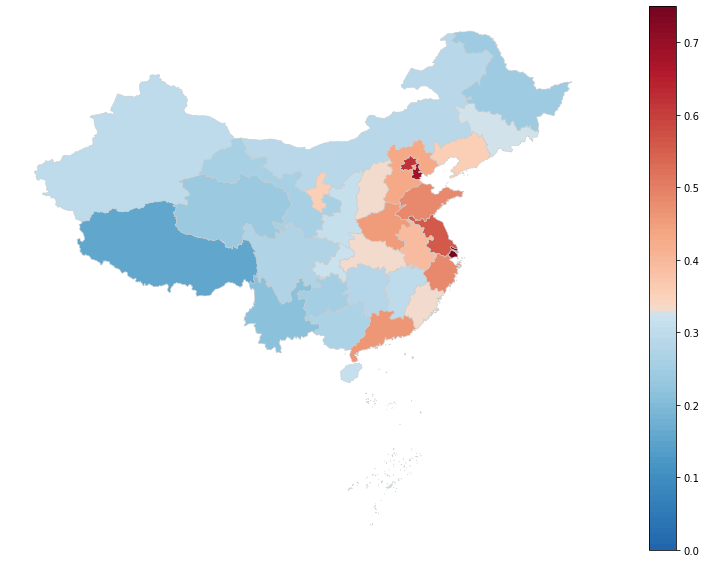

In [438]:
%matplotlib inline

# set a variable that will call whatever column we want to visualise on the map
variable = 'pro_score'
# set the range for the choropleth
vmin, vmax = 0, 0.75
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False) 
ax.get_xaxis().set_visible(False) 

res3.plot(column=variable, cmap=bwr_10,k=10,vmin=vmin,vmax=vmax,
          linewidth=0.5, ax=ax, edgecolor='0.8',legend=True)

### 展示图片

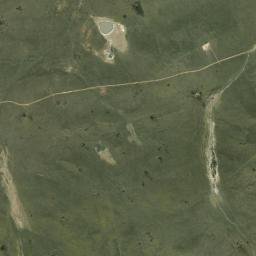

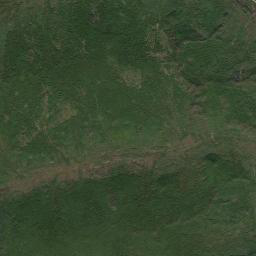

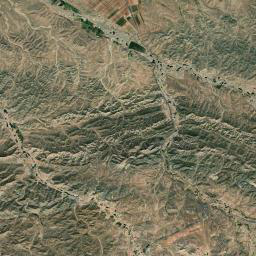

In [471]:
for i in np.arange(40,81,20):
    
    per_low = np.percentile(df['predict_norm'], i-20)
    per_high = np.percentile(df['predict_norm'], i)
    name = df[(df['predict_norm']>per_low)&(df['predict_norm']<per_high)]['name'].iloc[17]
    im = Image.open('/home/haoying/data_zl12/'+name)
    im.show()
# df[df['predict_norm']<np.percentile(df['predict_norm'], 20)]

## 处理经济数据

In [27]:
# ##处理经济数据
pp = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=0)
aa = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=1)
gg = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=2)
e1 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=3)
e2 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=4)
e3 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=5)
e4 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=6)
e5 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=7)
e6 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=8)
e7 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=9)
e8 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=10)
e9 = pd.read_excel('/home/haoying/经济指标.xlsx',sheet_name=11)

In [28]:
mm1 = pd.merge(pp,aa,how='outer')
mm2 = pd.merge(mm1,gg,how='outer')
mm3 = pd.merge(mm2,e1,how='outer')
mm4 = pd.merge(mm3,e2,how='outer')
mm5 = pd.merge(mm4,e3,how='outer')
mm6 = pd.merge(mm5,e4,how='outer')
mm7 = pd.merge(mm6,e5,how='outer')
mm8 = pd.merge(mm7,e6,how='outer')
mm9 = pd.merge(mm8,e7,how='outer')
mm10 = pd.merge(mm9,e8,how='outer')
mm11 = pd.merge(mm10,e9,how='outer')

mm11

,县,年末总人口,行政区域土地面积（平方公里）,地区生产总值（万元）,第一产业增加值（万元）,第二产业增加值（万元）,第三产业增加值（万元）,地方财政一般预算收入（万元）（2003年及之前为“地方财政预算内收入”）,地方财政一般预算支出（万元）（2003年及之前为“财政总支出”）,各项税收（万元）,城乡居民储蓄存款余额（万元）,人均地区生产总值（元/人）,规模以上工业总产值（现价）（万元）
0,北京市大兴区,188.8,1036.0,9075500.0,120817.0,2771752.0,6182931.0,1025124.0,2563258.0,612283.0,14631390.0,NaN,8200436.0
1,北京市怀柔区,42.2,2123.0,3998605.0,64449.0,1638864.0,2295292.0,431062.0,1472445.0,296629.0,3033126.0,NaN,5763354.4
2,北京市平谷区,46.2,948.0,2934891.0,131728.0,770869.0,2032294.0,242172.0,1270620.0,166183.0,2440117.0,NaN,1445898.4
3,北京市密云区,50.3,2226.0,3409331.0,136377.0,1018689.0,2254265.0,374560.0,1636764.0,267123.0,3240519.0,NaN,2924197.8
4,北京市延庆区,35.7,1995.0,1952859.0,74073.0,509725.0,1369061.0,214461.0,1283115.0,133216.0,2277822.0,NaN,1102134.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690,克拉玛依市独山子区,NaN,NaN,NaN,NaN,NaN,NaN,120138.0,139813.0,NaN,NaN,NaN,4268937.3
2691,克拉玛依市白碱滩区,NaN,NaN,NaN,NaN,NaN,NaN,61174.0,138343.0,NaN,NaN,NaN,323254.2
2692,克拉玛依市乌尔禾区,NaN,NaN,NaN,NaN,NaN,NaN,20013.0,NaN,NaN,NaN,NaN,66300.8
2693,乌鲁木齐市新市区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4093222.0


In [29]:
import urllib.request, urllib.parse, urllib.error
import json
import hashlib


MyAK = '1Xj9kRKcU5ExDn8P8gCY4mzMu6b9bOxq'
MySK = 'Cq0UsESBfgIgluHt9ry5RvptEM6bqb9s'
lat = 0
lng = 0
dictjson = {}  # 声明一个字典

def JingWei(address):
    global lat, lng
    # 产生sn码
    queryStr = "/geocoding/v3/?address=" + address + '&output=json&ak=' + MyAK
    encodedStr = urllib.parse.quote(queryStr, safe="/:=&?#+!$,;'@()*[]")
    rawStr = encodedStr + MySK
    sn = (hashlib.md5(urllib.parse.quote_plus(rawStr).encode("utf8")).hexdigest())

    # 生成url
    url = urllib.parse.quote("http://api.map.baidu.com" + queryStr + "&sn=" + sn, safe="/:=&?#+!$,;'@()*[]")

    # 从API读取数据
    uh = urllib.request.urlopen(url)
    data = uh.read().decode()

    # 解析数据
    try:
        js = json.loads(data)
    except:
        js = None

    if not js or 'status' not in js or js['status'] != 0:
#         print('======Failure====')
#         print(data)
        return None

#     print(json.dumps(js, indent=4, ensure_ascii=False))
    else:
        # 获取经纬度坐标和地址类型
        lat = js["result"]["location"]["lat"]
        lng = js["result"]["location"]["lng"]
    #     print('纬度', lat, '经度', lng)
        level = js["result"]["level"]
    #     print('地址类型', level)
        return lat,lng


# 基于百度地图API下的经纬度信息来解析地理位置信息
def getlocation(lat, lng):
#     print(lat,"ss",lng)
    url = '/reverse_geocoding/v3/?ak='+MyAK+'&output=json&coordtype=wgs84ll&location='+str(lat)+','+str(lng)
    encodedStr = urllib.parse.quote(url, safe="/:=&?#+!$,;'@()*[]")
    rawStr = encodedStr + MySK
    sn = (hashlib.md5(urllib.parse.quote_plus(rawStr).encode("utf8")).hexdigest())
    # 生成url
    url = urllib.parse.quote("http://api.map.baidu.com" + url + "&sn=" + sn, safe="/:=&?#+!$,;'@()*[]")
#     print('Retrieving', url)
    req = urllib.request.urlopen(url)  # json格式的返回数据
    res = req.read().decode("utf-8")  # 将其他编码的字符串解码成unicode
#     print(json.loads(res))
    return json.loads(res)


def jsonFormat(lat, lng):
    str = getlocation(lat, lng)
    global dictjson
    dictjson={}
    # get()获取json里面的数据
    jsonResult = str.get('result')
    address = jsonResult.get('addressComponent')
    # 国家
    country = address.get('country')
    # 国家编号（0：中国）
    country_code = address.get('country_code')
    # 省
    province = address.get('province')
    # 城市
    city = address.get('city')
    # 城市等级
    city_level = address.get('city_level')
    # 县级
    district = address.get('district')
    # 区划代码
    adcode=address.get('adcode')
    # 街道
    street=address.get('street')
    # 街道编号
    street_number=address.get('street_number')
    # 把获取到的值，添加到字典里（添加）
    # dictjson['country']=country
    dictjson['province'] = province
    dictjson['city'] = city
    dictjson['district'] = district
#     dictjson['province'] = province+city+district+street+street_number
    dictjson['adcode'] = adcode
    # dictjson['city_level'] = city_level
    # dictjson['district']=district
    return dictjson




res = jsonFormat(JingWei("北京市大兴区")[0],JingWei("北京市大兴区")[1])
res.get('province'),res.get('city'),res.get('district'),res.get('adcode')

('北京市', '北京市', '大兴区', '110115')

In [32]:
province,city,district,adcode = [],[],[],[]
adcode = []
for n,i in enumerate(mm11['县']):
    if n % 100 == 0:
        print(n)
    if JingWei(i):
        res = jsonFormat(JingWei(i)[0],JingWei(i)[1])
        province.append(res.get('province'))
        city.append(res.get('city'))
        district.append(res.get('district'))
        adcode.append(res.get('adcode'))
    else:
        print(i)
        province.append(None)
        city.append(None)
        district.append(None)
        adcode.append(None)        
#     print(ac)
#     adcode.append(ac)

0
100
邢台县
任县
南和县
200
300
400
500
600
繁昌县
芜湖县
700
龙海市
长泰县
800
蓬莱市
长岛县
900
偃师市
孟津县
1000
1100
监利县
仙桃市
天门市
潜江市
1200
祁阳县
1300
横县
1400
文昌市
琼海市
万宁市
澄迈县
东方市
五指山市
1500
新津县
1600
会理县
水城县
1700
黔西县
1800
禄丰县
1900
凤翔县
旬阳县
2000
2100
同仁县
2200
大石桥市
海门市
2300
龙南县
2400
2500
2600


In [33]:
len(adcode),len(province),len(city),len(district)

(2695, 2695, 2695, 2695)

In [34]:
mm11['adcode'] = adcode
mm11['province'] = province
mm11['city'] = city
mm11['district'] = district

In [36]:
len(mm11[pd.isnull(mm11['adcode'])])

34

In [40]:
for i in mm11[pd.isnull(mm11['adcode'])]['县']:
    if len(county_shp[county_shp['name']==i])!=0:
#         print(i)
        mm11.loc[mm11['县']==i,'adcode'] = county_shp.loc[county_shp['name']==i,'adcode'].values[0]
        print(mm11.loc[mm11['县']==i,'adcode'])
#         print(county_shp[county_shp['name']==i]['adcode'])

1197    429004
Name: adcode, dtype: object
1198    429006
Name: adcode, dtype: object
1199    429005
Name: adcode, dtype: object
1434    469005
Name: adcode, dtype: object
1435    469002
Name: adcode, dtype: object
1436    469006
Name: adcode, dtype: object
1439    469023
Name: adcode, dtype: object
1444    469007
Name: adcode, dtype: object
1449    469001
Name: adcode, dtype: object
2207    210882
Name: adcode, dtype: object


In [41]:
len(mm11[pd.isnull(mm11['adcode'])])

24

## 相关性

In [6]:
# mm11 = pd.read_csv('/home/haoying/eco.csv')
# mm11['adcode'] = mm11['adcode'].apply(lambda x :str(x)[:6])

In [33]:
# res2.to_csv('/home/haoying/all_score_eff_zl12.csv',index=0)
res = pd.read_csv('/home/haoying/all_score_eff_zl12.csv')
# res

In [11]:
df2 = df1.groupby('PAC').agg({'predict':'mean','name':'count','nightlights':'mean'}).reset_index()

In [35]:
# res = pd.merge(df2,mm11,left_on='PAC',right_on = 'adcode',how='left')
res[['score','地区生产总值（万元）']].corr('spearman')
# res[['predict','地区生产总值（万元）']].corr('pearson')

,score,地区生产总值（万元）
score,1.000000,0.664586
地区生产总值（万元）,0.664586,1.000000


In [15]:
res[['predict','年末总人口']].corr('spearman')

,predict,年末总人口
predict,1.000000,0.485036
年末总人口,0.485036,1.000000


In [16]:
import math
res['log_地区生产总值（万元）'] = res['地区生产总值（万元）'].apply(lambda x: math.log(x) if x>0  else x)
res[['predict','log_地区生产总值（万元）']].corr('spearman')

,predict,log_地区生产总值（万元）
predict,1.000000,0.660312
log_地区生产总值（万元）,0.660312,1.000000


In [18]:
res['score2'] = res['predict']*res['predict']

In [22]:
for i in res.columns[5:-7]:
    print(i,res[['predict',i]].corr().iloc[1,0],res[['predict',i]].corr('spearman').iloc[1,0])

年末总人口 0.4158361455935487 0.4850357747027401
行政区域土地面积（平方公里） -0.33050088935406385 -0.7133217311478676
地区生产总值（万元） 0.5042291820844426 0.6603122842298371
第一产业增加值（万元） 0.17228618570050044 0.2635647227342527
第二产业增加值（万元） 0.5260867663925273 0.6493190661361287
第三产业增加值（万元） 0.40882193062031136 0.6503358941814427
地方财政一般预算收入（万元）（2003年及之前为“地方财政预算内收入”） 0.458205926763741 0.6311240924737834
地方财政一般预算支出（万元）（2003年及之前为“财政总支出”） 0.36873468454713665 0.3570337293245517
各项税收（万元） 0.5511125896754422 0.7276587464389397
城乡居民储蓄存款余额（万元） 0.5942558730769052 0.6882053907635791
人均地区生产总值（元/人） 0.49665225009456815 0.47652181296229135


In [26]:
# 修正后的指数
# res = res.drop(['PAC','childrenNu','level','subFeature','ID','县'],axis=1)
# res['predict']*res['pic_num']*95/res['行政区域土地面积（平方公里）'] + res['predict'].mean()*(res['行政区域土地面积（平方公里）']-res['pic_num']*95)
res['log_行政区域土地面积（平方公里）'] = res['行政区域土地面积（平方公里）'].apply(lambda x: math.log(x) if x>0  else x)
res['pre_adj'] = res['predict']/res['log_行政区域土地面积（平方公里）'] 

for i in res.columns[5:-8]:
    print(i,res[['pre_adj',i]].corr().iloc[1,0],res[['pre_adj',i]].corr('spearman').iloc[1,0])

年末总人口 0.376570396598631 0.38453678904358585
行政区域土地面积（平方公里） 0.25765189158147367 0.19929331028161987
地区生产总值（万元） 0.43309402010679665 0.3882053993650231
第一产业增加值（万元） 0.31364228515156717 0.32547913460329386
第二产业增加值（万元） 0.4223249960356151 0.334293194306485
第三产业增加值（万元） 0.3959486823352538 0.3590122904577374
地方财政一般预算收入（万元）（2003年及之前为“地方财政预算内收入”） 0.4037809841027306 0.4053905405424911
地方财政一般预算支出（万元）（2003年及之前为“财政总支出”） 0.42054966744607925 0.389406728982024
各项税收（万元） 0.5627696889155479 0.5503079951230785
城乡居民储蓄存款余额（万元） 0.46123185507454584 0.3921118401841341
人均地区生产总值（元/人） 0.3343686977647433 0.2879678283445511
规模以上工业总产值（现价）（万元） 0.3258514986427682 0.16006306351133937


In [27]:
res['产业'] = res['第二产业增加值（万元）']+ res['第三产业增加值（万元）']
res[['predict','产业']].corr()

,predict,产业
predict,1.000000,0.507402
产业,0.507402,1.000000


In [105]:
# mm11.to_csv('/home/haoying/eco.csv',index=0)

## 分地区

In [48]:
prov_code['11']

'北京市'

In [36]:
# res['adcode'] = res['adcode'].astype(str)

# pd.merge(county_shp,res)

In [37]:
prov_code = {'11':'北京市','13':'河北省','14':'山西省','15':'内蒙古自治区','21':'辽宁省','22':'吉林省','23':'黑龙江省',
            '32':'江苏省','33':'浙江省','34':'安徽省','35':'福建省','36':'江西省','37':'山东省',
             '41':'河南省','42':'湖北省','43':'湖南省','44':'广东省','45':'广西壮族自治区','46':'海南省',
            '51':'四川省','52':'贵州省','53':'云南省','54':'西藏自治区',
            '61':'陕西省','62':'甘肃省','63':'青海省','64':'宁夏回族自治区','65':'新疆维吾尔自治区'}

test = res[(pd.notnull(res['score'])&pd.isnull(res['province']))]
for a,b in zip(test.name, test.parent): 
    prov = prov_code[str(b)[:2]]
    res.loc[res['name']==a,'province'] = prov

In [38]:
def get_diqu(x):
    if x in ['北京市','天津市','河北省','上海市','江苏省','浙江省','福建省','山东省','广东省','海南省']:
        return '东部'
    elif x in ['山西省','安徽省','江西省','河南省','湖北省','湖南省']:
        return '中部'
    elif x in ['内蒙古自治区','广西壮族自治区','重庆市','四川省','贵州省','云南省','西藏自治区','陕西省','甘肃省','青海省','宁夏回族自治区','新疆维吾尔自治区']:
        return '西部'
    elif x in ['辽宁省','吉林省','黑龙江省']:
        return '东北'
    else:
        return None

In [39]:
res['地区'] = res['province'].apply(lambda x : get_diqu(x))

In [40]:
res['地区'].value_counts()

西部    1118
东部     776
中部     708
东北     263
Name: 地区, dtype: int64

In [42]:
(pd.isnull(res['province'])).sum()

59

In [46]:
res.columns

Index(['adcode', 'name', 'childrenNu', 'level', 'parent', 'subFeature',
       'geometry', 'ID', 'score', '县', '年末总人口', '行政区域土地面积（平方公里）', '地区生产总值（万元）',
       '第一产业增加值（万元）', '第二产业增加值（万元）', '第三产业增加值（万元）',
       '地方财政一般预算收入（万元）（2003年及之前为“地方财政预算内收入”）',
       '地方财政一般预算支出（万元）（2003年及之前为“财政总支出”）', '各项税收（万元）', '城乡居民储蓄存款余额（万元）',
       '人均地区生产总值（元/人）', '规模以上工业总产值（现价）（万元）', 'province', 'city', 'district',
       'log_地区生产总值（万元）', 'pre_adj', 'log_行政区域土地面积（平方公里）', '产业', '地区'],
      dtype='object')

In [48]:
for i in ['西部','东部','中部','东北']:
    res_dis = res[res['地区']==i]
    for j in res_dis.columns[10:-9]:
        print(i,j,res_dis[['score',j]].corr().iloc[1,0],res_dis[['score',j]].corr('spearman').iloc[1,0])

西部 年末总人口 0.37474154261581993 0.4666528478979076
西部 行政区域土地面积（平方公里） -0.17811508267759413 -0.47567083277433403
西部 地区生产总值（万元） 0.6055333765380456 0.6559686257364556
西部 第一产业增加值（万元） 0.18498764300263493 0.37408140640667953
西部 第二产业增加值（万元） 0.5000555276859568 0.6142629451667659
西部 第三产业增加值（万元） 0.5905384444032192 0.623239130638347
西部 地方财政一般预算收入（万元）（2003年及之前为“地方财政预算内收入”） 0.5316250620851539 0.596021627459025
西部 地方财政一般预算支出（万元）（2003年及之前为“财政总支出”） 0.31992829016322255 0.3583480290247322
西部 各项税收（万元） nan nan
西部 城乡居民储蓄存款余额（万元） 0.6112065578159186 0.6173225966905115
西部 人均地区生产总值（元/人） 0.448044854582186 0.4393019940953902
东部 年末总人口 0.4389108203560212 0.4992883996922578
东部 行政区域土地面积（平方公里） -0.5230023515433697 -0.5597388932467875
东部 地区生产总值（万元） 0.5528845023600376 0.5673842143787389
东部 第一产业增加值（万元） -0.01277200762614933 0.07698403977862131
东部 第二产业增加值（万元） 0.5811605033241377 0.5502926146549887
东部 第三产业增加值（万元） 0.4399213710775995 0.5780100952989503
东部 地方财政一般预算收入（万元）（2003年及之前为“地方财政预算内收入”） 0.5090937751558934 0.5931133005873633
东

## 泰尔指数
##### 全国-中东西-各省

In [50]:
res.dropna(subset=['score'], inplace=True)

In [60]:
# 全国
import math
def get_theil(x):
    n = len(x)
    x_avg = np.mean(x)
    t_x = [(i/x_avg)*math.log(i/x_avg) for i in x]
    t = sum(t_x)/n
    return t
get_theil(res['score'])

0.004335626614987129

In [82]:
nt = df1.groupby('PAC').agg({'predict':'mean','name':'count','nightlights':'mean'}).reset_index()
res['adcode'] = res['adcode'].astype(str)


In [84]:
res2 = pd.merge(res,nt,left_on='adcode',right_on='PAC',how='left')

In [54]:
res1 = res.dropna(subset=['地区生产总值（万元）'], inplace=True)

In [99]:
get_theil(res2['predict'])

0.004335626614987117

In [100]:
# 中东西
t_in = 0
t_out = 0
for i in ['西部','东部','中部','东北']:
    res_dis = res[res['地区']==i]
    # 各地区theil指数
    t_i = get_theil(res_dis['score'])
#     print(t_i)
#     print(i,get_theil(res_dis['predict']))
    # 样本个数之比
    num_p = len(res_dis)/len(res)
#     print(num_p)
    # 指数和之比
    index_p = sum(res_dis['score']) /sum(res['score'])
    ## 区域内差异
    t_in += t_i*index_p
    ## 区域间差异
    t_out += index_p*math.log(index_p/num_p)
    ## 贡献率
    p = t_i * index_p /get_theil(res['score'])
    
    print(i,p)
print('区域内',t_in,'区域间',t_out)
print(t_in/get_theil(res['score']),t_out/get_theil(res['score']))
   

西部 0.27726941794791304
东部 0.25256536525140294
中部 0.2215665260099288
东北 0.03601528948825382
区域内 0.003413944362395515 区域间 0.0009216822525914845
0.7874165986974987 0.2125834013024714


In [42]:
# 分省
# 中东西

for i in ['西部','东部','中部','东北']:
    res_dis = res[res['地区']==i]
    t_in = 0
    t_out = 0
    p_all = 0
    for j in res_dis['province'].unique():
        pro_data = res_dis[res_dis['province']==j]
        # 各地区theil指数
        t_i = get_theil(pro_data['predict'])
        # 样本个数之比
        num_p = len(pro_data)/len(res_dis)
        # 指数和之比
        index_p = sum(pro_data['predict']) /sum(res_dis['predict'])
        ## 区域内差异
        t_in += t_i*index_p
        ## 区域间差异
        t_out += index_p*math.log(index_p/num_p)
        ## 贡献率
        p = t_i * index_p /get_theil(res_dis['predict'])
        p_all += p
        print(j,p)
    
    print(i,'区域内',t_in,'区域间',t_out)
    print(p_all)
    print(t_in/get_theil(res[res['地区']==i]['predict']),t_out/get_theil(res[res['地区']==i]['predict']))

NameError: name 'get_theil' is not defined